# Data Challenge 2: Employee Retention

## Framing the problem

### A company is interested in predicting when employees are going to quit by understanding variables that influence that decision. They want to know:
1. What are the main factors that drive employee churn? Do they make sense? Explain your findings.
1. What might you be able to do for the company to address employee Churn, what would be follow-up actions?
1. If you could add to this data set just one variable that could help explain employee churn, what would that be?

### Translated into actions, these might be rewritten as:
1. What features are important when predicting churn?
1. How does feature importance provide actionable insight?
1. What's missing?

## Quick Answers:
1. Salary and seniority were the most important. When removed from the models, being in the engineering department or in companies 1 or 5 as important. 
1. Organizations benefit from focusing on fewer, experienced employees that are paid well. 
1. Department and company mattered once salary and seniority were removed. However, there wasn't a clear difference between departments or companies in terms of the proportion of participants were still working vs. churned. But, something is different in engineering and companies 1 and 5. Working with a domain expert to identify potential variables for future data collection would likely help. 

## Exploring, cleaning, and preprocessing data

In [2]:
# Packages we'll be using
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
%matplotlib inline

In [3]:
# Read in the data
raw = pd.read_csv('employee_retention.csv')
raw = raw.drop(['Unnamed: 0'], axis=1)
raw.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,1001444.0,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25
1,388804.0,8,design,21,191000.0,05.17.2011,2012-03-16
2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10
3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30
4,1006393.0,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18


In [4]:
# Chek data types
data = raw.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34702 entries, 0 to 34701
Data columns (total 7 columns):
employee_id    34702 non-null float64
company_id     34702 non-null int64
dept           34702 non-null object
seniority      34702 non-null int64
salary         34463 non-null float64
join_date      34702 non-null object
quit_date      23510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.9+ MB


In [5]:
# Create outcome variable of whether the individual is still working (i.e., 0, 1). We'll use this for classification later on. 
from datetime import timedelta
data['working'] = np.where(data.quit_date.isna(), 1, 0)

In [6]:
# Convert errors in datetime entry objects to datetime data types
data['quit_date'] = data.fillna('2015-12-13')
date_cols = ['join_date', 'quit_date']
for i in date_cols:
    data[i] = pd.to_datetime(data[i])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34702 entries, 0 to 34701
Data columns (total 8 columns):
employee_id    34702 non-null float64
company_id     34702 non-null int64
dept           34702 non-null object
seniority      34702 non-null int64
salary         34463 non-null float64
join_date      34702 non-null datetime64[ns]
quit_date      34702 non-null datetime64[ns]
working        34702 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(3), object(1)
memory usage: 2.1+ MB


In [7]:
# Create feature for time on the job (i.e., delta end-start). We'll use this to try to predict how days until churn. 
data['duration_worked'] = (data['join_date'] - data['quit_date']).dt.days
data['join_date'] = [x.year for x in data['join_date']]
data['quit_date'] = [x.year for x in data['quit_date']]
data_cols = list(data)

In [8]:
# Check how unique vals and missing data for each feature. 
data = data.dropna()
for i in data_cols:
    print("Missing:", data[i].isna().sum(), "\n", data[i].value_counts(), "\n")

Missing: 0 
 330596.0     1
1003669.0    1
1003655.0    1
370756.0     1
1003657.0    1
            ..
825374.0     1
173576.0     1
628769.0     1
478226.0     1
512.0        1
Name: employee_id, Length: 34463, dtype: int64 

Missing: 0 
 1     9423
2     5178
3     3748
4     3046
5     2734
6     2243
7     2170
8     2011
9     1998
10    1873
12      23
11      16
Name: company_id, dtype: int64 

Missing: 0 
 temp_contractor     10000
customer_service     9089
engineer             4569
data_science         3157
sales                3148
marketing            3133
design               1367
Name: dept, dtype: int64 

Missing: 0 
 0     10000
8       996
12      978
6       939
9       933
2       931
16      931
5       925
10      920
11      919
7       917
14      912
15      903
19      902
4       886
13      886
17      881
3       868
18      861
1       858
20      838
23      782
21      770
22      758
24      737
25      708
26      683
27      634
29      625
28      580


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a195a3290>,
      dtype=object)

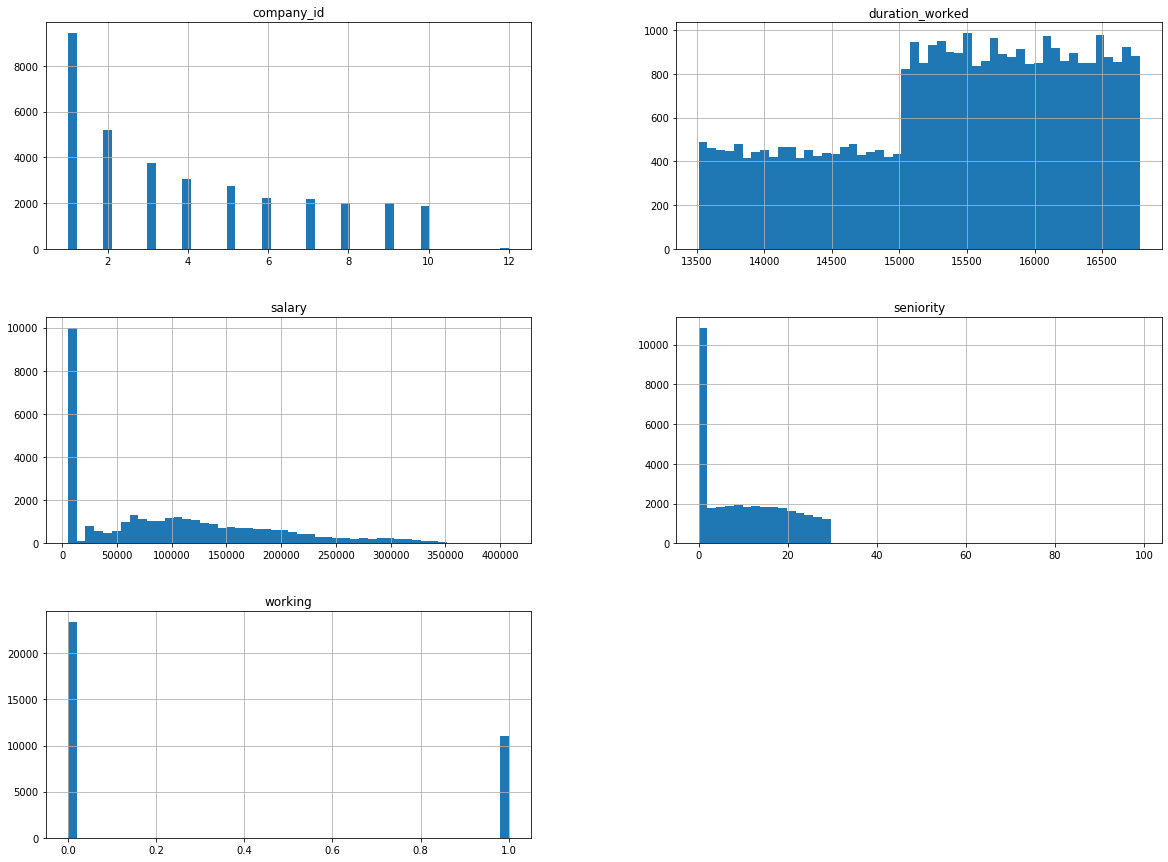

In [9]:
# Plot histogram of the different variables to see how things are shaking out. 
plot_cols = ['company_id', 'duration_worked', 'salary', 'seniority', 'working']
data[plot_cols].hist(bins=50, figsize=(20,15))

In [10]:
# It looks like the temp_contractor positions are making our data funky. 
# Let's remove them as they're irrelevant to the question at hand and might throw off our results. 
data = data[data.dept != 'temp_contractor']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b702fd0>,
      dtype=object)

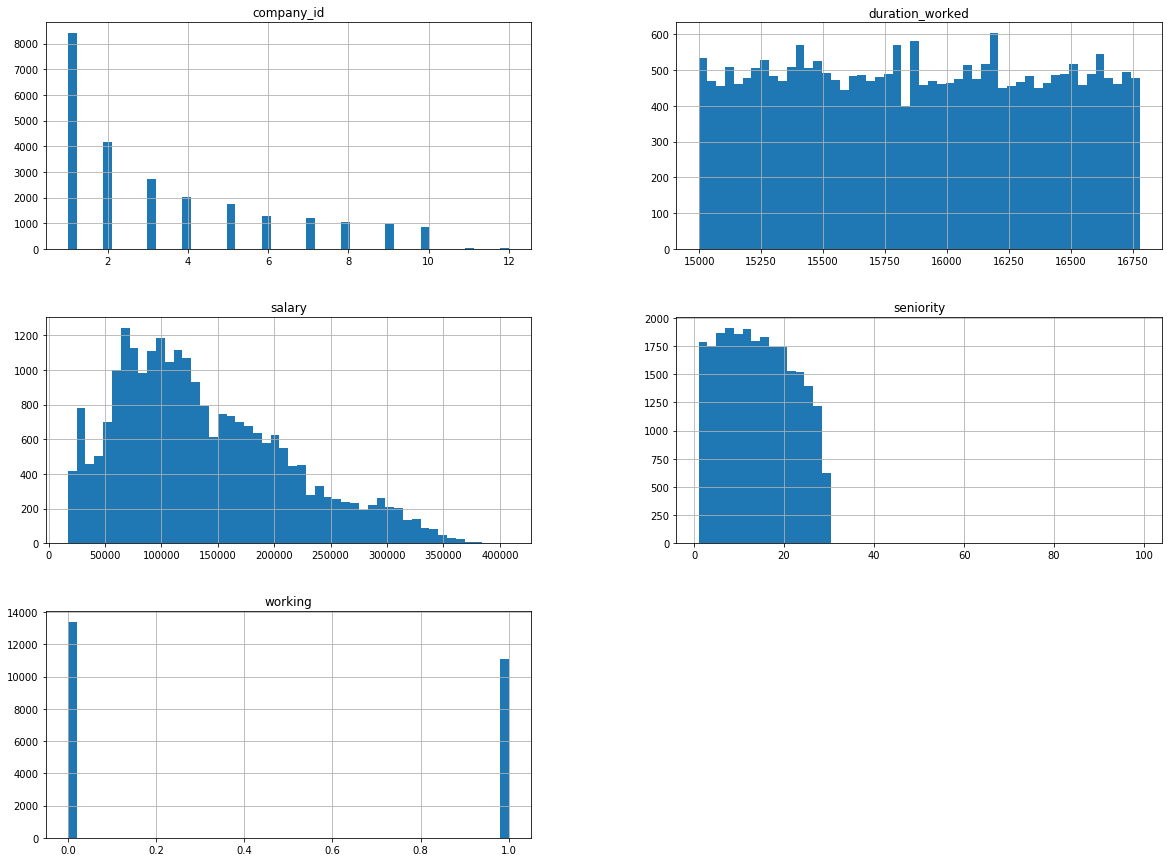

In [11]:
# Plot histogram of the different variables with the temp_contractors removed. 
plot_cols = ['company_id', 'duration_worked', 'salary', 'seniority', 'working']
data[plot_cols].hist(bins=50, figsize=(20,15))

### It looks like: 
- The number of people from different companies is a bit unequal. Keep that tucked in our back pocket for later. __Opportunity for model improvement__
- Duration worked looks like an uniform distribution. This may or may not be helpful. __Opportunity for model improvement__
- Whether they're still working looks fairly balanced.

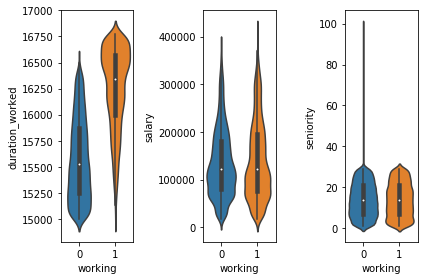

In [12]:
# Plot the relationship between each feature as a function of still working or not. 
import seaborn as sns
vio_cols = ['duration_worked', 'salary', 'seniority']
def vio_plot(df):
    f, axes = plt.subplots(1, 3)
    sns.violinplot(x='working', y='duration_worked', data=df, ax=axes[0])
    sns.violinplot(x='working', y='salary', data=df, ax=axes[1])
    sns.violinplot(x='working', y='seniority', data=df, ax=axes[2])
    plt.subplots_adjust(left=0.25, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)
    plt.tight_layout()
vio_plot(data)

### It looks like there's a solid difference here. These features should be helpful for a first pass!

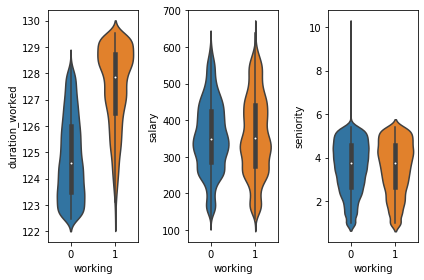

In [13]:
# These variables also seem a bit skewed. Let's see what different transformations do. 
# Square root transform
sqrt_test = data.copy()
for i in vio_cols:
    sqrt_test[i] = sqrt_test[i].transform(np.sqrt)
vio_plot(sqrt_test)

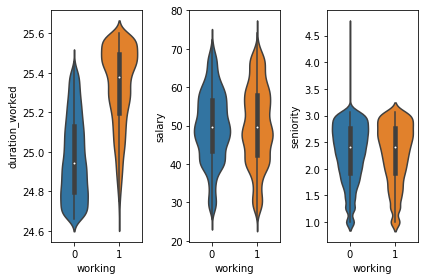

In [14]:
# Cube root transform
cube_root = data.copy()
for i in vio_cols:
    cube_root[i] = cube_root[i].transform(np.cbrt)
vio_plot(cube_root)

### Transforming doesn't seem to do too much. Left as is. 

# Baseline models. 
## Goal is to identify factors influencing churn. Two options for predictions:
1. Time to when they quit (i.e., duration worked at company is outcome variable - continuous). 
1. Are they still working at the company (i.e., classification task - binary).

## Let's create the feature and outcome dfs.

In [15]:
features = data.drop(['quit_date', 'working', 'duration_worked', 'join_date', 'employee_id'], axis=1)
outcomes = data[['quit_date', 'working', 'duration_worked', 'join_date', 'employee_id']]

In [16]:
# Recode necessary features via one-hot encoding
cols_recode = ['company_id', 'dept']
features = pd.get_dummies(features, columns = cols_recode)
features.shape # Check out the new shape

(24463, 20)

In [17]:
# Feature scaling 
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
scalar.fit(features)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
# Some packages
import matplotlib
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Some functions we'll use. 
def lin_metrics(x, y):
    ''' Prints four common metrics for evaluating regression predictions. '''
    print('Mean Absolute Error:', round(metrics.mean_absolute_error(x, y), 4))
    print('Mean Squared Error:', round(metrics.mean_squared_error(x, y), 4))
    print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(x, y)), 4))
    print('R^2 Math:,', round(metrics.r2_score(y_test, y_pred), 4))

def plot_scatter(x, y, xmin=None, xmax=None, ymin=None, ymax=None):
    '''Plots simple scatter plot of two datasets. We'll use to plot scatter of residuals.'''
    plt.scatter(x, y, cmap='viridis', alpha=0.1)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Observed', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    return plt.show()

def plot_residuals(x, y):
    '''Plot historgram of residuals.'''
    residuals = x - y
    plt.hist(residuals, bins=50, color='black')
    plt.xlabel('Residual')
    plt.ylabel('Num Observations')
    plt.show()

def bin_metrics(x, y):
    '''Prints four common metrics for evaluating classification predictions.'''
    print('Accuracy:', round(metrics.accuracy_score(x, y), 4))
    print('Precision:', round(metrics.precision_score(x, y), 4))
    print('Recall:', round(metrics.recall_score(x, y), 4))
    print('ROC_AUC:,', round(metrics.roc_auc_score(x, y), 4))
    print('F1:', round(metrics.f1_score(x, y), 4))

def plot_cm(x, y):
    cm = confusion_matrix(x, y)
    df_cm = pd.DataFrame(cm, columns=np.unique(x), index = np.unique(x))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 20}, fmt='g')# font size
    plt.ylim([0, 2])

def return_coef(model, feature_names):
    feats_list = model.coef_
    rounded = [round(x, 3) for x in feats_list] # Round coefficients
    feats_coef = list(zip(feature_names, rounded)) # Zip the feature names to the respective coefficients
    res = sorted(feats_coef, key = lambda x: x[1]) # Sort the list by the coefficient vals (lowest-to-highest)
    return print("\nModel Coeff:\n", res)

## Let's start with the models for the continuous outcome variables. Options include:
1. Linear regression (simple, straightforward, good place to start). 
1. Lasso regression (see if we can reduce the feature space while maintaining accuracy). 
1. ElasticNet ((see if we can reduce the feature space while maintaining accuracy). 
#### NB: Because we're interested in feature importance, algorithms that do not provide that information are off the table (e.g., kNN). 

Mean Absolute Error: 445.1379
Mean Squared Error: 264640.3761
Root Mean Squared Error: 514.4321
R^2 Math:, -0.0012

Model Coeff:
 [('company_id_11', -117.907), ('company_id_12', -64.171), ('dept_data_science', -12.964), ('dept_engineer', -7.462), ('dept_design', -6.818), ('seniority', -0.691), ('salary', 0.0), ('dept_sales', 2.478), ('company_id_5', 5.657), ('company_id_7', 9.281), ('dept_marketing', 11.626), ('company_id_1', 11.636), ('dept_customer_service', 13.14), ('company_id_10', 14.587), ('company_id_4', 18.731), ('company_id_8', 19.514), ('company_id_9', 20.667), ('company_id_6', 23.925), ('company_id_2', 24.182), ('company_id_3', 33.898)]


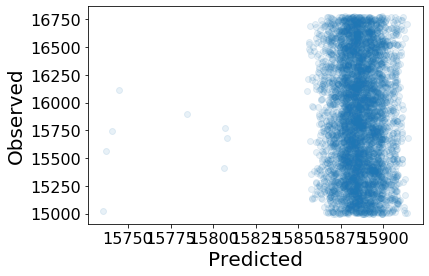

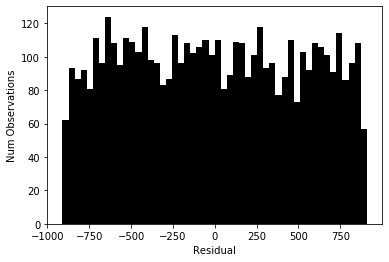

In [34]:
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(features, outcomes['duration_worked'], test_size=0.20, random_state = 333)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
lin_metrics(y_test, y_pred)
return_coef(model=regressor, feature_names=features)
plot_scatter(y_pred, y_test)
plot_residuals(y_test, y_pred)

## Maybe things improve with regularization?

Max R^2: -0.00040612219929081483


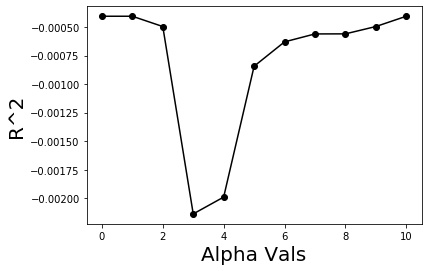

In [35]:
from sklearn.linear_model import Lasso
X_train, X_test, y_train, y_test = train_test_split(features, outcomes['duration_worked'], test_size=0.20, random_state = 649)
lasso_acc = []
pot_alphas = [1e100, 1e10, 1e5, 0.01, 0.1, 1, 10, 100, 1000, 100000, 10000000000]
for i in pot_alphas:
    model_lasso = Lasso(alpha=i)
    model_lasso.fit(X_train, y_train) 
    pred_train_lasso= model_lasso.predict(X_train)
    pred_test_lasso= model_lasso.predict(X_test)
    r_2 = metrics.r2_score(y_test, pred_test_lasso)
    lasso_acc.append(r_2)
plt.plot(lasso_acc, marker='o', color='black')
plt.ylabel('R^2', fontsize=20)
plt.xlabel('Alpha Vals', fontsize=20)
print("Max R^2:", max(lasso_acc))

## TAKEAWAY FROM CONTINUOUS PREDICTION: 
- Current variables did not allow for prediction of days-to-churn using the three algorithms tested. 
- Alternatively algorithms may have performed better. 

# Classification models
1. Logistic regression
1. SVM
1. Random Forest
1. Linear SVC

## Logistic Classifier:
- Advantages: less prone to over-fitting (except with high-dimensional data); gives size and direction of predictors; easy to implement, interpret, and train. 
- Disadvantages: assumption of linearity between variables

Accuracy: 0.5438
Precision: 0.0
Recall: 0.0
ROC_AUC:, 0.5
F1: 0.0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


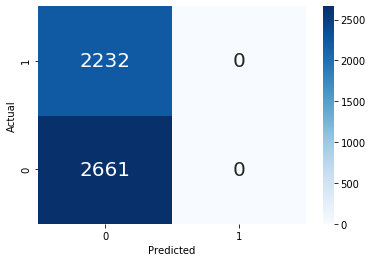

In [50]:
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(features,  outcomes['working'], test_size=0.20, random_state=649)
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
bin_metrics(y_test, y_pred)
plot_cm(y_test, y_pred)

## Support Vector Machine:
- Advantages: Effective in high dimensional spaces and uses a subset of training points in the decision function so it is memory efficient.
- Disadvantages: Does not directly provide probability estimates but are calculated using expensive five-fold cross-validation.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Max Accuracy: 0.5438
Max F1: 0.6265


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


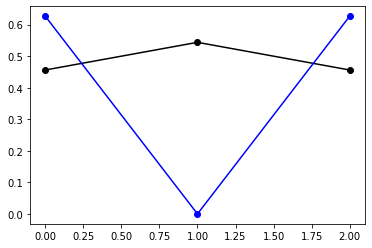

In [43]:
# Try a linear kernel to start. 
from sklearn import svm
X_train, X_test, y_train, y_test = train_test_split(features,  outcomes['working'], test_size=0.20, random_state = 649)
acc_scores = []
f1_scores = []
C_range = [0.01, 1, 100]
for i in C_range:
    classifier = svm.LinearSVC(C=i, max_iter=10000)
    classifier.fit(X_train, y_train)
    pred_train= classifier.predict(X_train)
    pred_test= classifier.predict(X_test)
    acc_val = metrics.accuracy_score(y_test, pred_test)
    acc_scores.append(acc_val)
    f1_val = metrics.f1_score(y_test, pred_test)
    f1_scores.append(f1_val)
plt.plot(acc_scores, marker='o', color='black')
plt.plot(f1_scores, marker='o', color='blue')
print("Max Accuracy:", round(max(acc_scores), 4))
print('Max F1:', round(max(f1_scores), 4))

Accuracy: 0.4562
Precision: 0.4562
Recall: 1.0
ROC_AUC:, 0.5
F1: 0.6265


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


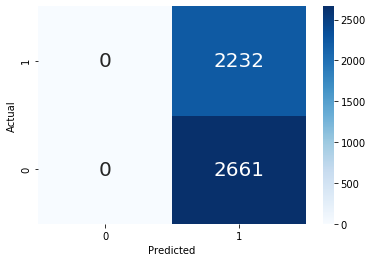

In [52]:
# What does the confusion matrix look like for the best SVM model?
X_train, X_test, y_train, y_test = train_test_split(features,  outcomes['working'], test_size=0.20, random_state = 649)
classifier = svm.LinearSVC(C=100, max_iter=10000)
classifier.fit(X_train, y_train)
pred_train= classifier.predict(X_train)
pred_test= classifier.predict(X_test)
bin_metrics(y_test, pred_test)
plot_cm(y_test, pred_test)

### The SVM with a linear kernel appears to be a dumb classifier. Let's try SVM with a nonlinear kernel. 

Max Accuracy: 0.54
Max F1: 0.4


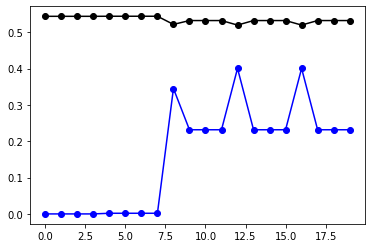

In [53]:
X_train, X_test, y_train, y_test = train_test_split(features,  outcomes['working'], test_size=0.20, random_state = 649)
acc_scores = []
f1_scores = []
C_range = [0.01, 0.1, 1, 10, 100]
gamma_range = [1, 10, 100, 1000]
for i in C_range:
    for k in gamma_range:
        classifier = svm.SVC(kernel = 'rbf', C=i, gamma=k)
        classifier.fit(X_train, y_train)
        pred_train= classifier.predict(X_train)
        pred_test= classifier.predict(X_test)
        acc_val = metrics.accuracy_score(y_test, pred_test)
        acc_scores.append(acc_val)
        f1_val = f1_score(y_test, pred_test)
        f1_scores.append(f1_val)
plt.plot(acc_scores, marker='o', color='black')
plt.plot(f1_scores, marker='o', color='blue')
print("Max Accuracy:", round(max(acc_scores), 2))
print('Max F1:', round(max(f1_scores), 2))

Accuracy: 0.5197
Precision: 0.465
Recall: 0.3517
ROC_AUC:, 0.5062
F1: 0.4005


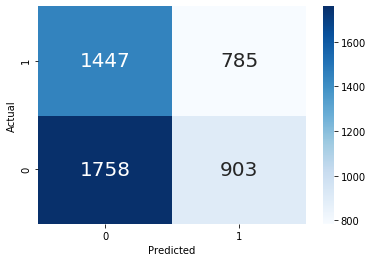

In [21]:
# What does the confusion matrix look like for the best SVM model with nonlinear kernel?
X_train, X_test, y_train, y_test = train_test_split(features,  outcomes['working'], test_size=0.20, random_state = 649)
classifier = svm.SVC(kernel = 'rbf', C=10, gamma=1)
classifier.fit(X_train, y_train)
pred_train= classifier.predict(X_train)
pred_test= classifier.predict(X_test)
bin_metrics(y_test, pred_test)
plot_cm(y_test, pred_test)

### Nice! At least the nonlinear kernel is doing better. Downside, though, is it doesn't give us feature importance. 

## Random Forest

Max Accuracy: 0.5555
Max F1: 0.4621


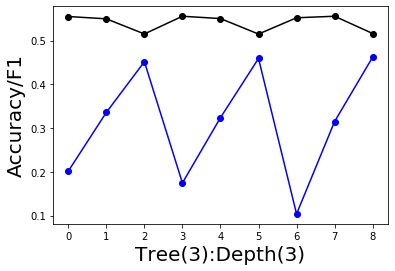

In [54]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(features,  outcomes['working'], test_size=0.20, random_state = 649)
acc_scores = []
f1_scores = []
nEst_range = [10, 50, 500]
depth_range = [2, 10, 100]
for i in nEst_range:
    for k in depth_range:
        classifier = RandomForestClassifier(n_estimators=i, max_depth=k)
        classifier.fit(X_train, y_train)
        pred_train= classifier.predict(X_train)
        pred_test= classifier.predict(X_test)
        acc_val = metrics.accuracy_score(y_test, pred_test)
        acc_scores.append(acc_val)
        f1_val = f1_score(y_test, pred_test)
        f1_scores.append(f1_val)
plt.plot(acc_scores, marker='o', color='black')
plt.plot(f1_scores, marker='o', color='blue')
plt.ylabel('Accuracy/F1', fontsize=20)
plt.xlabel('Tree(3):Depth(3)', fontsize=20)
print("Max Accuracy:", round(max(acc_scores), 4))
print('Max F1:', round(max(f1_scores), 4))

Accuracy: 0.516
Precision: 0.4668
Recall: 0.4279
ROC_AUC:, 0.5089
F1: 0.4465


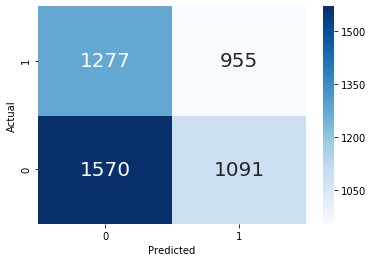

In [23]:
# Create best model to get feature importance
X_train, X_test, y_train, y_test = train_test_split(features,  outcomes['working'], test_size=0.20, random_state = 649)
classifier = RandomForestClassifier(n_estimators=10, max_depth=100)
classifier.fit(X_train, y_train)
pred_train= classifier.predict(X_train)
pred_test= classifier.predict(X_test)
acc_val = metrics.accuracy_score(y_test, pred_test)
f1_val = f1_score(y_test, pred_test)
bin_metrics(y_test, pred_test)
plot_cm(y_test, pred_test)

### The RF results are comparable in accuracy and F1 to the best we've seen thus far. Let's see what features are most important. 

In [24]:
feature_importances = pd.DataFrame(classifier.feature_importances_, index = X_train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances.head(20))

                       importance
salary                   0.670915
seniority                0.268133
company_id_3             0.005292
company_id_1             0.005237
company_id_4             0.005156
company_id_2             0.004809
company_id_9             0.004637
company_id_6             0.004378
company_id_5             0.004294
company_id_8             0.004153
company_id_7             0.003262
company_id_10            0.003205
dept_marketing           0.003166
dept_engineer            0.002875
dept_design              0.002741
dept_sales               0.002722
dept_data_science        0.002343
dept_customer_service    0.001293
company_id_11            0.000749
company_id_12            0.000640


### It looks like there's no shortage for compensation and seniority. There might be some *minor* differences in company ID and department. But these are small in comparison. 
### Let's see what happens if we remove salary and seniority from the model. 

Accuracy: 0.5481
Precision: 0.5145
Recall: 0.1671
ROC_AUC:, 0.5174
F1: 0.2523


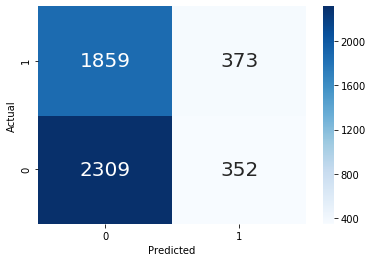

In [27]:
# Create best model to get feature importance
new_feats = features.drop(['salary', 'seniority'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(new_feats,  outcomes['working'], test_size=0.20, random_state = 649)
classifier = RandomForestClassifier(n_estimators=10, max_depth=100)
classifier.fit(X_train, y_train)
pred_train= classifier.predict(X_train)
pred_test= classifier.predict(X_test)
acc_val = metrics.accuracy_score(y_test, pred_test)
f1_val = f1_score(y_test, pred_test)
bin_metrics(y_test, pred_test)
plot_cm(y_test, pred_test)

In [28]:
feature_importances = pd.DataFrame(classifier.feature_importances_, index = X_train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances.head(20))

                       importance
dept_engineer            0.148818
company_id_5             0.074019
company_id_1             0.073151
dept_customer_service    0.070563
dept_sales               0.067620
company_id_2             0.066525
company_id_10            0.062329
dept_marketing           0.055485
company_id_6             0.054714
dept_data_science        0.045825
dept_design              0.044960
company_id_7             0.042054
company_id_9             0.040524
company_id_4             0.035897
company_id_12            0.033928
company_id_8             0.029774
company_id_3             0.029114
company_id_11            0.024701


### Looks like there's some nice, additional info here. 
- Someone should talk with the engineering department, customer service, and sales departments to determine how they differ from other departments (plots below don't suggest anything significant). 
- Same for companies (plots below don't suggest anything significant). 

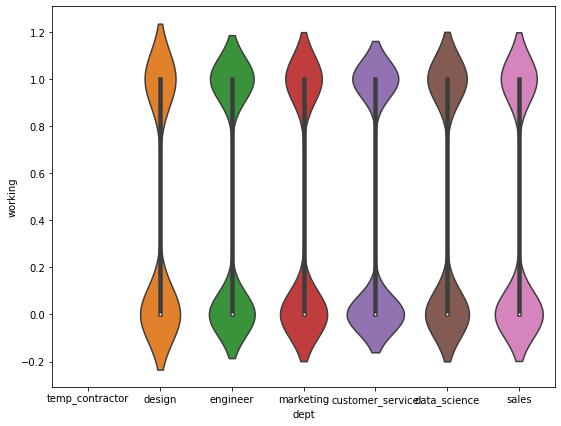

In [47]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.violinplot(ax=ax, x = data_2['dept'], y = data['working'])

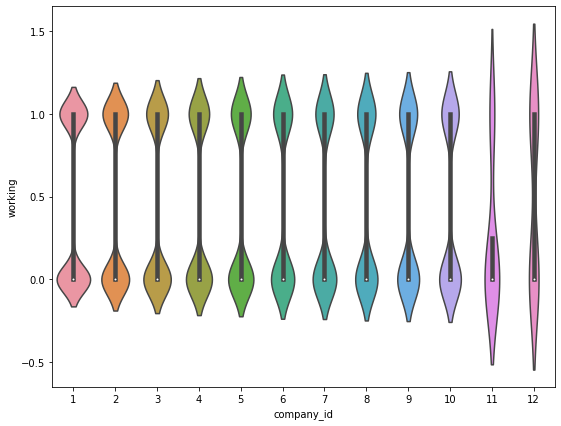

In [48]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.violinplot(ax=ax, x = data_2['company_id'], y = data['working'])

### For S&G: Nearest Neighbor

Max Accuracy: 0.54
Max F1: 0.46


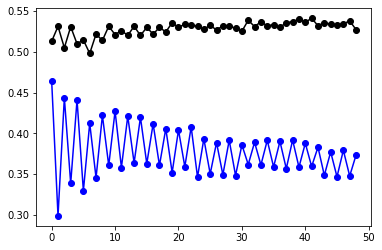

In [57]:
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(features,  outcomes['working'], test_size=0.20, random_state = 649)
acc_scores = []
f1_scores = []
neigh_range = list(range(1, 50))
for i in neigh_range:
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(X_train, y_train)
    pred_train= classifier.predict(X_train)
    pred_test= classifier.predict(X_test)
    acc_val = metrics.accuracy_score(y_test, pred_test)
    acc_scores.append(acc_val)
    f1_val = f1_score(y_test, pred_test)
    f1_scores.append(f1_val)
plt.plot(acc_scores, marker='o', color='black')
plt.plot(f1_scores, marker='o', color='blue')
print("Max Accuracy:", round(max(acc_scores), 2))
print('Max F1:', round(max(f1_scores), 2))